In [1]:
# !pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="3j9KnCrn3vCKxbGLZmCp")
project = rf.workspace("fernando-vela-rdnuo").project("medicineboxes")
version = project.version(1)
dataset = version.download("coco")
                

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to MedicineBoxes-1 in coco:: 100%|██████████| 2867/2867 [00:00<00:00, 7885.65it/s]


In [9]:
import os
HOME = os.getcwd()
print(HOME)

/Users/baiporthn/Documents/MedicineBoxReg/code


In [24]:
import os
import torchvision
import torch
from PIL import Image
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import random
import json
import matplotlib.pyplot as plt

In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [18]:
dataset = os.path.join(HOME, 'MedicineBoxes-1')
# Settings
ANNOTATION_FILE_NAME = "_annotations.coco.json"
TRAIN_DIRECTORY = os.path.join(dataset, "train")
VAL_DIRECTORY = os.path.join(dataset, "valid")
TEST_DIRECTORY = os.path.join(dataset, "test")

def convert_bbox_tocrop(box):
    """function convert bbox from annotation or prediction
    bbox format = [x_min, y_min, width, height] 
    crop area = [x_min, y_min, x_max, y_max]
    input box: list
    return crop_area: list
    """
    x_min = box[0]
    y_min = box[1]
    width = box[2]
    height = box[3]
    x_max = x_min + width
    y_max = y_min + height
    crop_area = [x_min, y_min, x_max, y_max]
    return crop_area
    
class CocoClassificationDataset(torchvision.datasets.CocoDetection):
    def __init__(self, image_directory_path: str, img_height=32, img_width=100, train=True):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoClassificationDataset, self).__init__(image_directory_path, annotation_file_path)
        self.img_height = img_height
        self.img_width = img_width

    def __getitem__(self, idx):
        # Get image and annotations using the parent class
        image, annotations = super(CocoClassificationDataset, self).__getitem__(idx)

        if annotations and 'bbox' in annotations[0]:
            bbox = annotations[0]['bbox']
            crop_bbox = convert_bbox_tocrop(bbox)
            image = image.crop(crop_bbox)
            # print("bbox", bbox)
            # print("crop_bbox", crop_bbox)
        # plt.imshow(image)
        # plt.axis("off")
        # plt.show()

        # Resize the cropped image and convert to RGB for classification
        image = image.convert('RGB')  # Convert to RGB
        image = image.resize((self.img_width, self.img_height), resample=Image.BILINEAR)
        image = np.array(image)  # Convert image to numpy array
        image = image.transpose((2, 0, 1))  # Transpose to (channels, height, width)
        image = (image / 127.5) - 1.0  # Normalize to [-1, 1]
        image = torch.FloatTensor(image)  # Convert to tensor

        # For classification, assume that the 'category_id' is the class label
        if annotations and 'category_id' in annotations[0]:
            class_label = annotations[0]['category_id']  # This is the class label for classification
        else:
            class_label = -1  # Handle case when the class label is missing (if necessary)
        
        # Convert class label to tensor
        target = torch.LongTensor([class_label])

        return image, target

# Custom collate function for batching
def coco_collate_fn(batch):
    images, targets = zip(*batch)
    
    images = torch.stack(images, 0)
    targets = torch.cat(targets, 0)
    return images, targets

# Randomly sample 20% of the dataset indices
def get_subset(dataset, percentage):
    total_size = len(dataset)
    subset_size = int(total_size * percentage)
    indices = random.sample(range(total_size), subset_size)
    return Subset(dataset, indices)



In [136]:
# Create datasets and dataloaders for classification
train_dataset = CocoClassificationDataset(
    image_directory_path=TRAIN_DIRECTORY,
    train=True)

val_dataset = CocoClassificationDataset(
    image_directory_path=VAL_DIRECTORY,
    train=False)

test_dataset = CocoClassificationDataset(
    image_directory_path=TEST_DIRECTORY,
    train=False)

percentage = 0.6
# Create subsets with 20% of the data
train_subset = get_subset(train_dataset, percentage)
val_subset = get_subset(val_dataset, percentage)
test_subset = get_subset(test_dataset, percentage)

# Check the sizes of the subsets
print("Total training data:", len(train_dataset))
print("Subset training data:", len(train_subset))
print("Total validation data:", len(val_dataset))
print("Subset validation data:", len(val_subset))
print("Total validation data:", len(test_subset))
print("Subset validation data:", len(test_subset))

# Create data loaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, collate_fn=coco_collate_fn)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False, collate_fn=coco_collate_fn)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False, collate_fn=coco_collate_fn)

# Check dataset sizes
print("Number of training examples:", len(train_subset))
print("Number of validation examples:", len(val_subset))
print("Number of test examples:", len(test_subset))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Total training data: 2661
Subset training data: 1596
Total validation data: 157
Subset validation data: 94
Total validation data: 24
Subset validation data: 24
Number of training examples: 1596
Number of validation examples: 94
Number of test examples: 24


In [31]:
# Path to your annotation file
annotation_file = os.path.join(TRAIN_DIRECTORY, "_annotations.coco.json")

# Load the annotation file
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

# Create a mapping of category_id to category_name
category_id_to_name = {category['id']: category['name'] for category in coco_data['categories']}
name_to_category_id = {v: k for k, v in category_id_to_name.items()}

# Example: Print the mapping
print("Category Mapping:", category_id_to_name)

Category Mapping: {0: 'Boxes', 1: 'aferin', 2: 'aljil', 3: 'apodonorm5mg', 4: 'apodorm5mg', 5: 'apranax', 6: 'arveles', 7: 'aspirin', 8: 'betasalic', 9: 'box', 10: 'buprefarm5ug_hour', 11: 'dikloron', 12: 'dolcontin10mg', 13: 'dolcontin5mg', 14: 'dolorex', 15: 'fentanyl50ug_ml', 16: 'hametanKrem', 17: 'hametanMerhem', 18: 'ibucoldC', 19: 'imovane7-5mg', 20: 'levopidon25mg', 21: 'majezik', 22: 'majezikmajezik', 23: 'metadon_hydrochlorid40mg', 24: 'metpamid', 25: 'midazolam5mg_ml', 26: 'morfin10mg', 27: 'nexium', 28: 'nobligan_retard200mg', 29: 'oxycontin10mg', 30: 'oxycontin15mg', 31: 'oxycontin5mg', 32: 'oxynorm10mg', 33: 'parol', 34: 'silverdin', 35: 'sobril25mg', 36: 'terbisil', 37: 'travazol', 38: 'ultiva5mg', 39: 'unisom', 40: 'valium5mg', 41: 'xanor2mg'}


tensor([ 9,  9,  1, 13])


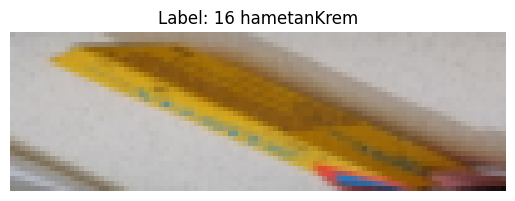

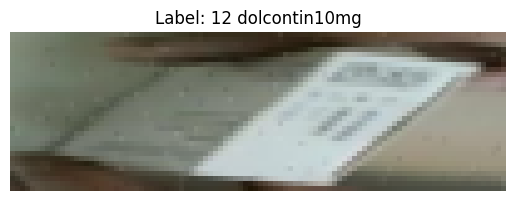

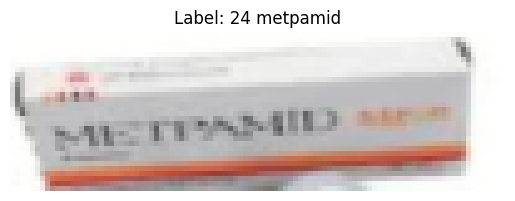

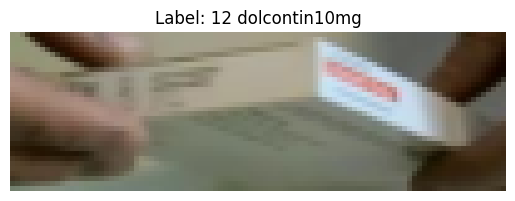

In [53]:

def show_image_with_label(image, label):
    """Display image with its readable label."""
    image = image.numpy().transpose((1, 2, 0))  # Convert (C, H, W) -> (H, W, C)
    image = (image + 1.0) / 2.0  # De-normalize from [-1, 1] to [0, 1]
    image = np.clip(image, 0, 1)  # Clip values to valid range
    plt.imshow(image)
    plt.title(f"Label: {label} {category_id_to_name.get(int(label))}")
    plt.axis("off")
    plt.show()
    
    
images, labels = next(iter(train_loader))
print(labels)
def display_batch(dataloader, num_images=5):
    images, labels = next(iter(dataloader))
    
    for i in range(min(num_images, len(images))):
        show_image_with_label(images[i], labels[i])

display_batch(train_loader, num_images=5)

In [71]:
class_names = [category['name'] for category in coco_data['categories']]
dataset_sizes = len(train_subset) + len(val_subset) + len(test_subset)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

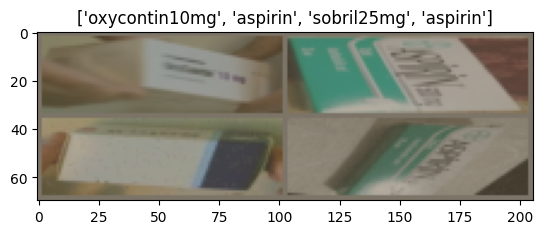

In [123]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=2)

imshow(out, title=[class_names[x] for x in classes])

In [127]:
import time
from tempfile import TemporaryDirectory

def train_model(model, criterion, optimizer, scheduler, num_epochs=25, train_loader=None, val_loader=None):
    since = time.time()

    # Initialize lists to store loss and accuracy for plotting
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Training phase
            model.train()  # Set model to training mode
            running_loss = 0.0
            running_corrects = 0

            # Iterate over training data
            for inputs, labels in train_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Validation phase
            model.eval()  # Set model to evaluate mode
            val_loss = 0.0
            val_corrects = 0

            with torch.no_grad():  # No gradients needed during validation
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Statistics
                    val_loss += loss.item() * inputs.size(0)
                    val_corrects += torch.sum(preds == labels.data)

            # Update learning rate scheduler
            scheduler.step()

            # Calculate losses and accuracies
            train_loss = running_loss / len(train_loader.dataset)
            train_acc = running_corrects.double() / len(train_loader.dataset)

            val_loss = val_loss / len(val_loader.dataset)
            val_acc = val_corrects.double() / len(val_loader.dataset)

            # Append the values for plotting
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            # Print the results
            print(f'Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f}')
            print(f'Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f}')

            # Deep copy the model if we have a new best validation accuracy
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), best_model_params_path)

            print()

        # Load the best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

    # Return losses and accuracies to plot
    return model, train_losses, train_accuracies, val_losses, val_accuracies


In [126]:
import matplotlib.pyplot as plt

def plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies, num_epochs):
    """
    Plot the learning curves for both loss and accuracy.

    Args:
        train_losses (list): List of training loss values for each epoch.
        train_accuracies (list): List of training accuracy values for each epoch.
        val_losses (list): List of validation loss values for each epoch.
        val_accuracies (list): List of validation accuracy values for each epoch.
        num_epochs (int): Number of epochs.

    Returns:
        None
    """
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(range(num_epochs), train_losses, label='Train Loss')
    plt.plot(range(num_epochs), val_losses, label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(num_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(num_epochs), val_accuracies, label='Val Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Show plots
    plt.tight_layout()
    plt.show()


In [122]:
def visualize_model(model, num_images=6, val_loader=val_loader, class_names=class_names, device='cpu'):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j].item()]}')

                # Call imshow to display the image
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)



In [91]:
## Load pre-trained IMAGENET1K_V1 reset final fully connected layer.

In [74]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 42)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Epoch 0/4
----------
Train Loss: 0.5134 Train Acc: 0.8452
Val Loss: 2.1743 Val Acc: 0.5484

Epoch 1/4
----------
Train Loss: 0.4312 Train Acc: 0.8715
Val Loss: 2.3930 Val Acc: 0.6774

Epoch 2/4
----------
Train Loss: 0.3605 Train Acc: 0.8933
Val Loss: 1.9889 Val Acc: 0.7419

Epoch 3/4
----------
Train Loss: 0.3258 Train Acc: 0.9068
Val Loss: 1.7287 Val Acc: 0.7419

Epoch 4/4
----------
Train Loss: 0.2711 Train Acc: 0.9196
Val Loss: 2.0125 Val Acc: 0.7097

Training complete in 1m 56s
Best val Acc: 0.741935


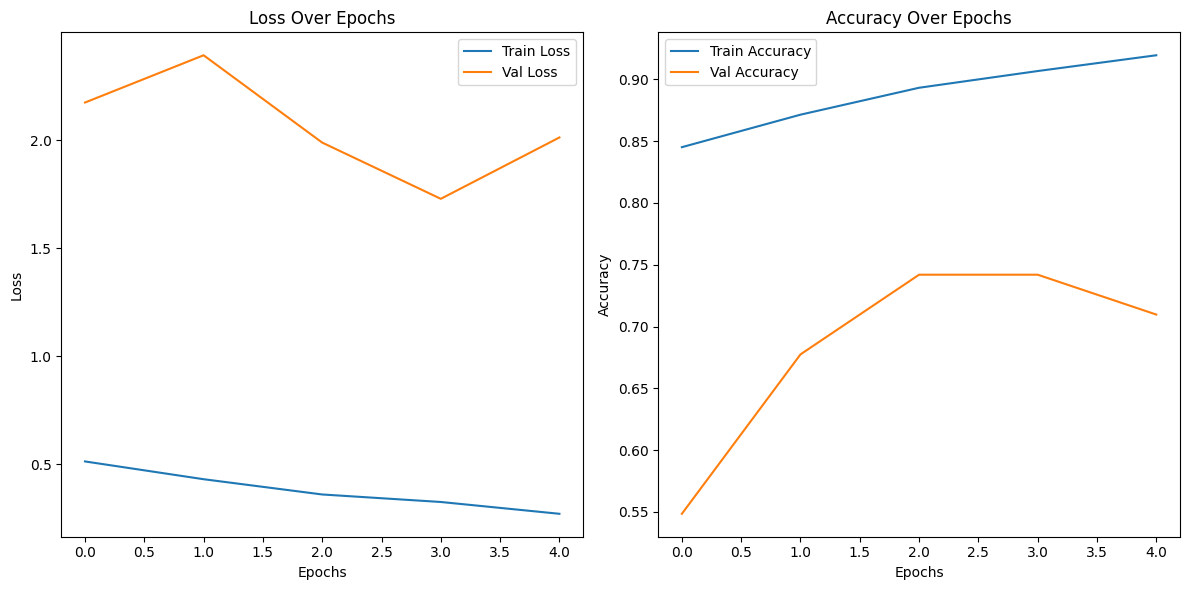

In [129]:
# Train the model
model_ft, train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5, train_loader=train_loader, val_loader=val_loader
)

# Plot the learning curves
plot_learning_curves(train_losses, train_accuracies, val_losses, val_accuracies, num_epochs=5)


In [131]:
#2. freeze all layers in the pre-trained ResNet50 only train the final fully connected layer 

#replace final fc layer
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 42)

#freeze Freezing the early layers
for param in model_ft.parameters():
    param.requires_grad = False
    
#unfreeze last fc
model_ft.fc.requires_grad = True

##
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train the model
model_ft, train_losses2, train_accuracies2, val_losses2, val_accuracies2 = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100, train_loader=train_loader, val_loader=val_loader
)

#convert acc into numpy array
train_accuracies2 = np.array([t.cpu().numpy() for t in train_accuracies2])
val_accuracies2 = np.array([t.cpu().numpy() for t in val_accuracies2])
# Plot the learning curves

plot_learning_curves(train_losses2, train_accuracies2, val_losses2, val_accuracies2, num_epochs=100)


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


Epoch 0/99
----------


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
#3. 
#3. freeze all layers in the pre-trained Effientnet only train the final fully connected layer 

#replace final fc layer
model_ft = models.EfficientNet(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 42)

#freeze Freezing the early layers
for param in model_ft.parameters():
    param.requires_grad = False
    
#unfreeze last fc
model_ft.fc.requires_grad = True

##
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train the model
model_ft, train_losses3, train_accuracies3, val_losses3, val_accuracies3 = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100, train_loader=train_loader, val_loader=val_loader
)

#convert acc into numpy array
train_accuracies3 = np.array([t.cpu().numpy() for t in train_accuracies3])
val_accuracies3 = np.array([t.cpu().numpy() for t in val_accuracies3])
# Plot the learning curves

plot_learning_curves(train_losses3, train_accuracies3, val_losses3, val_accuracies3, num_epochs=100)


In [ ]:
#3. 
#4. VGG freeze all layers in the pre-trained  only train the final fully connected layer 

#replace final fc layer
model_ft = models.vgg16(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 42)

#freeze Freezing the early layers
for param in model_ft.parameters():
    param.requires_grad = False
    
#unfreeze last fc
model_ft.fc.requires_grad = True

##
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train the model
model_ft, train_losses3, train_accuracies3, val_losses3, val_accuracies3 = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100, train_loader=train_loader, val_loader=val_loader
)

#convert acc into numpy array
train_accuracies3 = np.array([t.cpu().numpy() for t in train_accuracies3])
val_accuracies3 = np.array([t.cpu().numpy() for t in val_accuracies3])
# Plot the learning curves

plot_learning_curves(train_losses3, train_accuracies3, val_losses3, val_accuracies3, num_epochs=100)


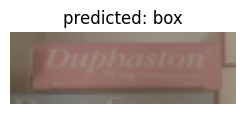

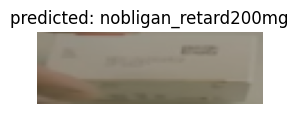

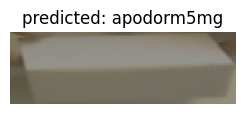

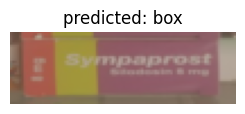

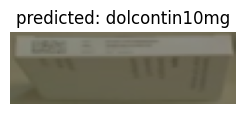

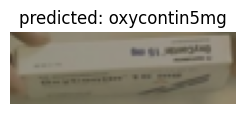

In [130]:
visualize_model(model_ft)

In [90]:
## freeze all the network except the final layer.

In [133]:
model_conv = torchvision.models.resnet50(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 42)
#unfreeze last fc
model_conv.fc.requires_grad = True
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.


In [135]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=2, train_loader=train_loader, val_loader=val_loader)

Epoch 0/1
----------


KeyboardInterrupt: 

In [98]:
# Custom img

In [99]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = transforms(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [104]:
# visualize_model_predictions(
#     model_conv,
#     img_path=os.path.join(dataset, 'valid/A-ferin19_jpg.rf.3747ba8a4d293f40a76d6d44437d9d72.jpg')
# )

# plt.ioff()
# plt.show()